# OWS Lib - WPS

This page demonstrates how to use the `owslib.wps` Python library to invoke our *SilverEye WPS microservice*. 

In [1]:
from owslib.wps import WebProcessingService
wps = WebProcessingService('https://api.silvereye.bccvl.org.au/wps', verbose=False, skip_caps=True)
wps.getcapabilities()
wps.identification.type

'WPS'

In [2]:
wps.identification.title

'PyWPS Processing Service'

In [3]:
wps.identification.abstract

'PyWPS is an implementation of the Web Processing Service standard from the Open Geospatial Consortium. PyWPS is written in Python.'

In [4]:
for operation in wps.operations:
    print(operation.name)

GetCapabilities
DescribeProcess
Execute


## What processes are supported?

In [5]:
for process in wps.processes:
    print("{:>30}: {}".format(process.identifier, process.title))

   process_one_year_all_months: ANUClim monthly aggregation for all months in one year.
 process_one_year_all_quarters: ANUClim quarterly aggregation for one whole year.
  process_one_year_month_range: ANUClim monthly aggregation within range of months in one year.
    process_one_year_one_month: ANUClim monthly aggregation for one month in one year.
  process_one_year_one_quarter: ANUClim quarterly aggregation for one quarter in one year.
      process_years_all_months: ANUClim monthly aggregation for all months in a range of years.
    process_years_all_quarters: ANUClim quarterly aggregation for a range of years.
       process_years_one_month: ANUClim monthly aggregation for only one month in a range of years.
     process_years_one_quarter: ANUClim quarterly aggregation for one quarter in a range of years.
              process_one_year: ANUClim yearly aggregation for one year.
                 process_years: ANUClim yearly aggregation for a range of years.
process_from_year_month

## Getting Process Descriptions

In [6]:
from owslib.wps import printInputOutput
process = wps.describeprocess('process_one_year_one_month')
process.identifier

'process_one_year_one_month'

In [7]:
process.title

'ANUClim monthly aggregation for one month in one year.'

In [8]:
process.abstract

'Computes a monthly statistical function for env vars at location and time from ANUClimate daily climate grids.'

In [9]:
for input in process.dataInputs:
    printInputOutput(input)
    print()

 identifier=variables, title=Variables to extract, abstract=None, data type=string
 Allowed Value: temp_max
 Allowed Value: temp_min
 Allowed Value: rainfall
 Allowed Value: solar_radiation
 Allowed Value: vapour_pressure
 Default Value: None 
 minOccurs=1, maxOccurs=5

 identifier=stfn, title=Statistical function to apply, abstract=None, data type=string
 Allowed Value: max
 Allowed Value: mean
 Allowed Value: median
 Allowed Value: min
 Allowed Value: std
 Allowed Value: var
 Default Value: None 
 minOccurs=0, maxOccurs=1

 identifier=year, title=Year to process in range 1970:2014, abstract=None, data type=integer
 Default Value: None 
 minOccurs=1, maxOccurs=1

 identifier=month, title=Month to process in range 1:12, abstract=None, data type=integer
 Default Value: None 
 minOccurs=1, maxOccurs=1

 identifier=lat_min, title=Latitude minimum value to process in range -43.735:-9.005, abstract=None, data type=float
 Default Value: None 
 minOccurs=1, maxOccurs=1

 identifier=lat_max, t

In [10]:
for output in process.processOutputs:
    printInputOutput(output)

 identifier=output, title=Metadata, abstract=None, data type=ComplexData
 Supported Value: mimeType=application/zip, encoding=None, schema=None
 Default Value: mimeType=application/zip, encoding=None, schema=None 
 reference=None, mimeType=None


## Execute a Process

In [10]:
processid = 'process_one_year_all_months'
inputs = [ 
    ("variables", "temp_max"),
    ("variables", "temp_min"),
    ("variables", "rainfall"),
    ("year", "2014"), ("stfn", "mean"),
    ("lat_min", "-28.135"), ("lat_max", "-28.105"),
    ("lon_min", "152.855"), ("lon_max", "152.875")
]
output = "OUTPUT"
execution = wps.execute(processid, inputs, output = "OUTPUT")
execution.getStatus()

'ProcessAccepted'

In [27]:
from owslib.wps import WebProcessingService
wps = WebProcessingService('https://api.silvereye.bccvl.org.au/wps', verbose=False, skip_caps=True)

processid = 'process_predefined_region_one_year_one_month'
inputs = [ 
    ("variables", "temp_max"), ("variables", "temp_min"), ("variables", "rainfall"),
    ("year", "2014"), ("month", "6"), ("stfn", "mean"),
    ("gdb_name", "ibra7_subregions_states"), ("rec_id", "347_QLD")
]
output = "OUTPUT"
execution = wps.execute(processid, inputs, output = "OUTPUT")
execution.getStatus()

'ProcessAccepted'

## Monitor Execution

In [11]:
execution.isSucceded()

False

In [12]:
execution.status

'ProcessAccepted'

In [13]:
execution.isComplete()

False

In [14]:
execution.errors

[]

In [15]:
def monitor_execution(execution, sleepSecs=5, download=False, filepath='data/out.zip'):
    while execution.isComplete() is False:
        execution.checkStatus(sleepSecs=sleepSecs)
        print('Execution status: {}'.format(execution.status))

    if execution.isSucceded():
        if download:
            execution.getOutput(filepath=filepath)
        else:
            for output in execution.processOutputs:
                if output.reference is not None:
                    print('Output URL={}'.format(output.reference))
    else:
        for ex in execution.errors:
            print('Error: code={}, locator={}, text={}'.format(ex.code, ex.locator, ex.text))

In [28]:
# the following line execute a request, and specifies where to put the result.

monitor_execution(execution, sleepSecs=5, download=True, filepath='workspace/data/out20200807.zip')

Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessSucceeded


In [31]:
filepath = 'workspace/data/out20200807.zip'

In [32]:
from zipfile import ZipFile
f = ZipFile(filepath)
print(f.namelist())
f.close()

['temp_min.csv', 'result.zarr', 'temp_max.tif', 'result.nc', 'metadata.json', 'rainfall.csv', 'temp_max.csv', 'temp_min.tif', 'result.csv', 'rainfall.tif']


In [33]:
# now we read the result
import xarray as xr

with ZipFile('data/out20200807.zip') as z:
    res = z.extract('result.nc', path='workspace/data/')
    xds = xr.load_dataset(res)
xds

<xarray.Dataset>
Dimensions:      (lat: 183, lon: 73, time: 1)
Coordinates:
  * lat          (lat) float64 -28.18 -28.16 -28.16 ... -26.36 -26.36 -26.34
  * lon          (lon) float64 152.8 152.8 152.8 152.9 ... 153.5 153.5 153.5
  * time         (time) datetime64[ns] 2014-06-01
    spatial_ref  int32 0
Data variables:
    rainfall     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    temp_min     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    temp_max     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    geospatial_lat_min:         -28.175
    geospatial_lat_max:         -26.335
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.01
    geospatial_lon_min:         152.825
    geospatial_lon_max:         153.545
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.01
    DOI:                        to be added
    licence_data_access:        These data can be freely downloaded and used
    keywords:                   EARTH SCIENCE > ATMOSPHERE
    summary:                    ANU Daily Data Cubes Sliced and Aggregated
    spatial_coverage:           Australia
    acknowledgement:            The creation of this data was funded by ecoCo...
    title:                      ANU Daily Data Cubes Aggregated
    institution:                Griffith University, Queensland
    contributor_name:           Silvereye, ecoCommons
    license:                    Attribution 4.0 International
    cdm_data_type:              grid
    contact:                    ecocommons@ecocommons.org.au
    source:                     ANUClimate_v1_1
    date_created:               2020-08-07
    publisher_name:             Silvereye microservice, ecoCommons Australia
    publisher_url:              https://ecocommons.org.au
    publisher_email:            ecocommons@ecocommons.org.au
    grid_mapping:               spatial_ref

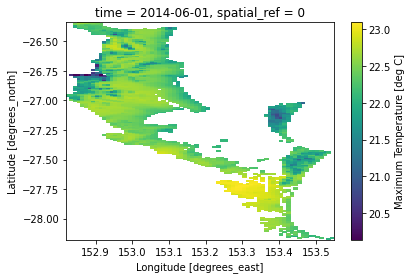

In [34]:
import xarray as xr
xds['temp_max'].sel({'time': '2014-06-01'}).plot()

## Executing a Pre-made WPS XML Request

In [22]:
request = open('workspace/data/wps/process_years.xml','rb').read()
execution = wps.execute(None, [], request=request)

In [23]:
monitor_execution(execution, sleepSecs=5, download=True, filepath='workspace/data/out55.zip')

Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution 

In [36]:
from zipfile import ZipFile
filepath = 'workspace/data/out55.zip'
f = ZipFile(filepath)
print(f.namelist())
f.close()

['temp_max_monthly_mean_2010-2014.tif', 'result_monthly_mean_2010-2014.csv', 'process_temp_min_monthly_mean_2010-2014.csv', 'process_rainfall_monthly_mean_2010-2014.csv', 'result_monthly_mean_2010-2014.zarr', 'temp_min_monthly_mean_2010-2014.tif', 'rainfall_monthly_mean_2010-2014.tif', 'result_monthly_mean_2010-2014.nc', 'process_temp_max_monthly_mean_2010-2014.csv']


### Simplified Monitoring - without a Named file download

In [37]:
request = open('workspace/data/wps/process_years.xml','rb').read()
execution = wps.execute(None, [], request=request)
monitor_execution(execution)

Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessStarted
Execution status: ProcessSucceeded
Output URL=https://api.silvereye.bccvl.org.au/outputs/47180400-c031-11ea-b965-ae181de6d2fb/out.zip


Use the Output URL above to download the resulting CSV output file.

In [38]:
import requests, io 
from zipfile import ZipFile
response = requests.get('https://api.silvereye.bccvl.org.au/outputs/47180400-c031-11ea-b965-ae181de6d2fb/out.zip')
zipinmemory = io.BytesIO(response.content)
f = ZipFile(zipinmemory)
print(f.namelist())
f.close()

['temp_max_monthly_mean_2010-2014.tif', 'result_monthly_mean_2010-2014.csv', 'process_temp_min_monthly_mean_2010-2014.csv', 'process_rainfall_monthly_mean_2010-2014.csv', 'result_monthly_mean_2010-2014.zarr', 'temp_min_monthly_mean_2010-2014.tif', 'rainfall_monthly_mean_2010-2014.tif', 'result_monthly_mean_2010-2014.nc', 'process_temp_max_monthly_mean_2010-2014.csv']


response = requests.get('https://api.silvereye.bccvl.org.au/outputs/966b6858-b6d6-11ea-bd85-6a89a330ec88/out.zip')
zipinmemory = io.BytesIO(response.content)
with ZipFile(zipinmemory) as z:
    with z.open('process_temp_max_monthly_mean_2014-Jun.csv') as zf:
        csv_df = pd.read_csv(zf)
csv_df

In [39]:
response = requests.get('https://api.silvereye.bccvl.org.au/outputs/47180400-c031-11ea-b965-ae181de6d2fb/out.zip')
zipinmemory = io.BytesIO(response.content)
with ZipFile(zipinmemory) as z:
    res = z.extract('result_monthly_mean_2010-2014.nc', path='workspace/data/')
    xds2 = xr.load_dataset(res)
xds2

<xarray.Dataset>
Dimensions:   (lat: 4, lon: 3, time: 60)
Coordinates:
  * time      (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2014-12-01
  * lat       (lat) float64 -28.23 -28.23 -28.25 -28.25
  * lon       (lon) float64 152.9 152.9 152.9
Data variables:
    temp_max  (time, lat, lon) float32 32.336956 32.294434 ... 30.35688
    temp_min  (time, lat, lon) float32 18.805424 18.799715 ... 18.277401
    rainfall  (time, lat, lon) float32 1.7657254 1.7485948 ... 5.886187
Attributes:
    geospatial_lat_min:         -28.225
    geospatial_lat_max:         -28.255
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.01
    geospatial_lon_min:         152.855
    geospatial_lon_max:         152.875
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.01
    DOI:                        to be added
    licence_data_access:        These data can be freely downloaded and used
    keywords:                   EARTH SCIENCE > ATMOSPHERE
    summary:                    ANU Daily Data Cubes Sliced and Aggregated
    spatial_coverage:           Australia
    acknowledgement:            The creation of this data was funded by ecoCo...
    title:                      ANU Daily Data Cubes Aggregated
    institution:                Griffith University, Queensland
    contributor_name:           Silvereye, ecoCommons
    license:                    Attribution 4.0 International
    cdm_data_type:              grid
    contact:                    ecocommons@griffith.edu.au
    source:                     ANUClimate_v1_1
    date_created:               2020-07-07
    publisher_name:             Silvereye microservice, ecoCommons Project
    publisher_url:              https://ardc.edu.au/project/ecocommons-austra...
    publisher_email:            ecocommons@griffith.edu.au

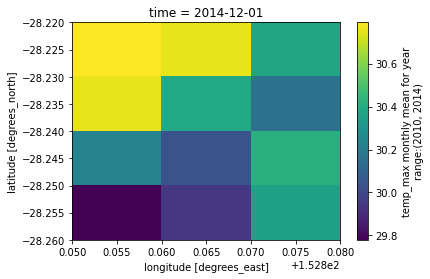

In [43]:
xds2['temp_max'].sel({'time':'2014-12-01'}).plot(x='lon', y='lat')

In [46]:
xds2['lon'].values[:3]

array([152.855, 152.865, 152.875])

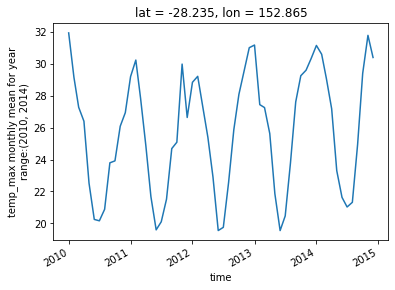

In [47]:
xds2['temp_max'].sel({'lat':-28.235, 'lon':152.865}).plot()